In [1]:
from numpy import array
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
from math import sqrt
from sklearn.metrics import mean_squared_error


c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# fixem random seed
numpy.random.seed(7)

dadesSau = read_csv('dadesSau.csv', sep=';',header=0, index_col=0)
dataframe = pd.DataFrame(dadesSau.loc[dadesSau.index >= '2009-01-01']['Volum'])
dataset = dataframe.values
dataset = dataset.astype('float32')


In [3]:
# Normalitzem

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = [item for sublist in dataset for item in sublist]


In [4]:
# transformem les dades a format seqüencia d'entrada i seqüencia de sortida
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


Definim una funció que ens retornarà els conjunts d'entrenament i test, segons les observacions d'entrada i sortida:

In [5]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [6]:
n_steps_in = 30
n_steps_out = 15
propTrainTest = 0.8
trainX, testX, trainY, testY = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)

Transformem l'entrada d'entrenament al format d'entrada de LSTM [samples,timesteps,features] En el nostre cas, univariant, features és 1 i samples i timesteps dependran del nombre de n_steps_in i n_steps_out

In [7]:
n_features = 1
train_X = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
test_X = testX.reshape((testX.shape[0], testX.shape[1], n_features))

In [8]:
model = Sequential()
model.add(LSTM(100, activation='sigmoid', input_shape=(n_steps_in, n_features)))
#model.add(LSTM(100, activation='sigmoid'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_X, trainY, epochs=100, verbose=0)


Fem les prediccions i retornem els valors a l'escala orginial

In [9]:
# prediccions
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


In [10]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [11]:
RMSE_TOT, RMSE_days = evaluate_forecasts(testY,testPredict)
print(RMSE_TOT)

6.06748152554213


In [17]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('step '+str(i+1))


table1 = tabulate([RMSE_days[0:10]], headers, tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[10:15]], headers[10:15], tablefmt="fancy_grid")
#output
print(table1)
print(table2)

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╕
│   step 1 │   step 2 │   step 3 │   step 4 │   step 5 │   step 6 │   step 7 │   step 8 │   step 9 │   step 10 │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│  1.73846 │  2.74692 │  3.27376 │  3.96945 │  4.37238 │   4.9379 │  5.53013 │  5.94604 │   6.3481 │   6.74073 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧═══════════╛
╒═══════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│   step 11 │   step 12 │   step 13 │   step 14 │   step 15 │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│   7.20405 │   7.62166 │   7.98834 │   8.43141 │   8.66653 │
╘═══════════╧═══════════╧═══════════╧═══════════╧═══════════╛


In [18]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(testY.shape[1]):
    # calculem MSE
    dies.append((testY[:, i], testPredict[:, i]))



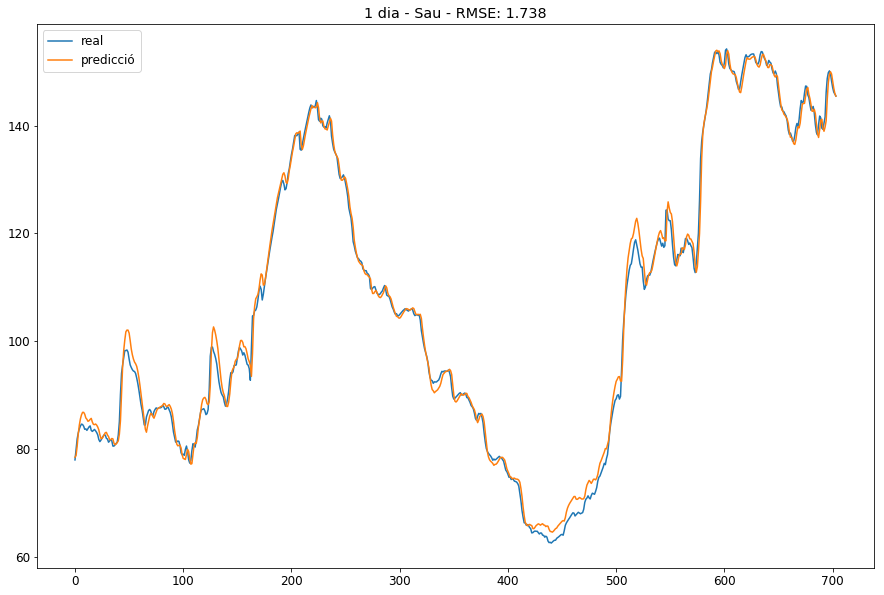

In [21]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
plt.rcParams.update({'font.size': 12})
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))

plt.plot(dies[0][0], label='real')
plt.plot(dies[0][1], label='predicció')
plt.legend()
plt.title(title1)


plt.show()

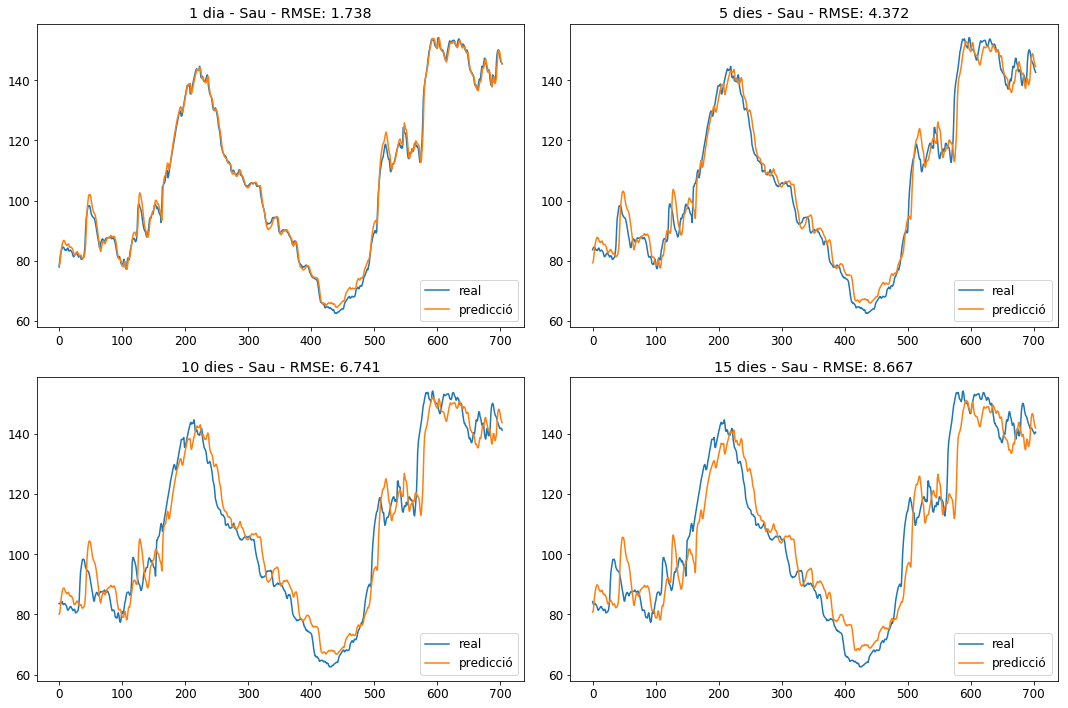

In [20]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()